<a href="https://colab.research.google.com/github/StephenWalther/ASPNETMVC5Workshop/blob/master/fast_slow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get secrets

from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
if OPENAI_API_KEY is None:
  raise ValueError('OPENAI_API_KEY not set in secrets')

LANGCHAIN_API_KEY=userdata.get('LANGCHAIN_API_KEY')
if LANGCHAIN_API_KEY is None:
  raise ValueError('LANGCHAIN_API_KEY not set in secrets')

In [ ]:
# Enable observability through LangSmith
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"] = "fast-slow"

In [ ]:
# Install packages

%pip install -U langchain_openai
%pip install -U openai

!apt-get update
!apt-get install -y xvfb
!apt-get install -y x11-xserver-utils

%pip install pyvirtualdisplay

%pip install -U langgraph langsmith
%pip install -U openai
%pip install -U playwright
!playwright install

%pip install -U playwright-stealth

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
# Enable virtual display for headful browser
"""
  LinkedIn will act differently when accessed with a headless browser.
  Therefore, we are instantiating a 1920x1080 browser with a virtual display.
"""

from pyvirtualdisplay import Display
from playwright.sync_api import sync_playwright
import os

display = Display(visible=1, size=(1920, 1080), backend='xvfb', extra_args=['-ac'])
display.start()

In [ ]:
# Define LangGraph State
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]



In [ ]:
# Define Navigate tool
import re
import random
import base64
from langchain_core.messages import HumanMessage
import json
from bs4 import BeautifulSoup


from langchain_core.tools import tool

screenshot_analysis_instructions = """
Analyze the picture of the web page to find all of the links and forms.  Return
the analysis using the following JSON format:
{
  "purpose" : string,
  "forms" : [{"description": string, "submit_button": string, "fields": [{"name": string, "type": string}],
  "links" : [{"label": string}]
}

The purpose field should describe the overall purpose of the web page using no
more than three sentences. The form description field should describe the
purpose of the form using no more than a single sentence.

Ensure that you find all of the links and all of the forms.
"""

def url_to_filename(url):
  """ Converts a URL to a basic, safe filename by replacing invalid characters with underscores.
  Args:
      url: The URL to convert.

  Returns:
      A safe filename derived from the URL.
  """
  # Remove protocol (http://, https://) and www.
  filename = re.sub(r"^(https?://)?(www\.)?", "", url)

  # Replace invalid characters with underscores
  filename = re.sub(r"[^a-zA-Z0-9._-]", "_", filename)

  #remove trailing _
  filename = filename.rstrip("_")

  return filename

async def get_screenshot(page, url):
  filename = url_to_filename(url) + '.png'
  print(f"File name: {filename}")


  # Capture a full-page screenshot
  await page.screenshot(path=filename, full_page=True)
  print(f"Screenshot saved as '{filename}'")

  return filename


async def parse_forms(html):
  print("Executing parse forms")
  # Parse the HTML content
  soup = BeautifulSoup(html, 'html.parser')

  # Initialize a list to store form data
  forms_data = []

  # Extract all forms
  forms = soup.find_all('form')

  # Iterate through each form
  for form in forms:
      form_id = form.get('id', 'No ID')
      form_fields = []

      # Find all form fields (input, select, textarea, button)
      fields = form.find_all(['input', 'select', 'textarea', 'button'])
      for field in fields:
          field_name = field.get('name', 'No name')
          field_id = field.get('id', 'No ID')
          placeholder = field.get('placeholder', 'No placeholder')
          # Find associated label if available
          label = 'No label'
          if field_id != 'No ID':
              label_tag = soup.find('label', {'for': field_id})
              if label_tag:
                  label = label_tag.text.strip()

          # Add field data to the form fields list
          form_fields.append({
              'type': field.name,
              'name': field_name,
              'id': field_id,
              'label': label,
              'placeholder': placeholder
          })

      # Add form data to the forms_data list
      forms_data.append({
          'form_id': form_id,
          'fields': form_fields
      })

  # Convert to JSON
  forms_json = json.dumps(forms_data, indent=4)

  # Print JSON
  print(forms_json)

async def get_screenshot_analysis(filename):
  llm_video = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)
  json_llm_video = llm.bind(response_format={"type": "json_object"})

  with open(filename, "rb") as file:
    file_data = file.read()

    # Encode the file data to Base64
    encoded_data = base64.b64encode(file_data).decode("utf-8")

    message = HumanMessage(
    content=[
        {"type": "text", "text": screenshot_analysis_instructions},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{encoded_data}"},
        },
    ]
  )
  ai_msg = await json_llm_video.ainvoke([message])
  print(ai_msg.content)

  return ai_msg.content


@tool
async def navigate(url: str):
  """Navigates to a specified URL."""

  # Need to create new page for concurrency
  page = await browser.new_page()
  await stealth_async(page)

  # Navigate to the page
  await page.wait_for_timeout(random.uniform(500, 1000))
  await page.goto(url, wait_until="load")

  # Get html
  html = await page.content()

  # Get screenshot
  filename = await get_screenshot(page, url)

  # Get Forms
  forms = await parse_forms(html)

  # Analyze screenshot
  analysis = await get_screenshot_analysis(filename);

  return f"debug: Finished navigating to: {url}"


tools = [navigate]

In [ ]:
# Define LangGraph Chatbot node
# https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html#langchain_openai.chat_models.base.ChatOpenAI

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
# Define LangGraph Graph
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


# Add edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)


graph = graph_builder.compile()

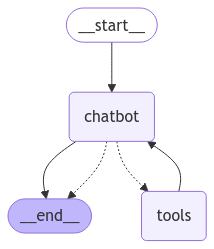

In [ ]:
# Show mermaid diagram
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Start the Graph

from playwright.async_api import async_playwright, BrowserContext
from playwright_stealth import stealth_async

# def stream_graph_updates(user_input: str):
#   for event in graph.stream({"messages": [("user", user_input)]}):
#       for value in event.values():
#           print("Assistant:", value["messages"][-1].content)


# while True:
#   user_input = input("User: ")
#   if user_input.lower() in ["quit", "exit", "q"]:
#       print("Goodbye!")
#       break

#   stream_graph_updates(user_input)




async def run_graph():
  # Create Playwright globals
  async with async_playwright() as playwright:
    # Init browser
    global browser
    # browser = await playwright.chromium.launch(headless=False)
    browser = await playwright.firefox.launch(headless=True)

    # # Define context options.
    # context_options: dict = {
    #     "user_agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36",
    #     "extra_http_headers" : {"Accept-Language": "en-US,en;q=0.9"}
    # }

    # context: BrowserContext = await browser.new_context(**context_options)



    while True:
      user_input = input("User: ")
      if user_input.lower() in ["quit", "exit", "q"]:
          print("Goodbye!")
          break

      # Init state and config
      initial_state = {"messages": [("user", user_input)]}
      config = {"configurable": {"thread_id": "1"}}

      # Start the graph
      async for event in graph.astream(initial_state, config, stream_mode="updates"):
          print(event)

      print("All done!")

# Kick everything off
await run_graph()




User: Navigate to a page where I can buy a rat
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_u3sdk07YbYSCyCVBiue4dtx6', 'function': {'arguments': '{"url": "https://www.petsmart.com/small-pet/live-pet/live-small-pets/rat-5272268.html"}', 'name': 'navigate'}, 'type': 'function'}, {'id': 'call_PW11IHcaG5RkarNTcuKs6B2L', 'function': {'arguments': '{"url": "https://www.petco.com/shop/en/petcostore/category/small-animals/live-small-pets"}', 'name': 'navigate'}, 'type': 'function'}, {'id': 'call_fxIDo9qcKUK71xeFJ6Z80s4B', 'function': {'arguments': '{"url": "https://www.joshsfrogs.com/animals/exotic-mammals/rodents/rats.html"}', 'name': 'navigate'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 121, 'prompt_tokens': 53, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_deta